In [1]:
import os 
from glob import glob

import numpy as np

import xarray as xr
import pandas as pd
import dask

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
from matplotlib.lines import Line2D
import cartopy.feature as cfeature
import nc_time_axis
import cftime

from utils.global_paths import project_data_path, project_code_path, loca_path

from matplotlib.colors import LinearSegmentedColormap, ListedColormap

cm_data = np.loadtxt("./utils/colormaps/lapaz.txt")[::-1]
lapaz_cmap = LinearSegmentedColormap.from_list("cmap", cm_data)

cm_data = np.loadtxt("./utils/colormaps/lajolla.txt")[::-1]
lajolla_cmap = LinearSegmentedColormap.from_list("cmap", cm_data)

In [3]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.5

# Soil moisture product intercomparison 

In [4]:
# Read all
obs_names = ['SMAP', 'VIC', 'NOAH', 'MOSAIC']

subset_name = 'eCONUS'

ds_obs_all = []

for obs_name in obs_names:
    ds = xr.open_dataset(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/{obs_name}_validation.nc")
    ds = ds.assign_coords(obs_name = obs_name)
    ds_obs_all.append(ds)

ds_obs_all = xr.concat(ds_obs_all, dim='obs_name').drop_vars('depth')['soilMoist']

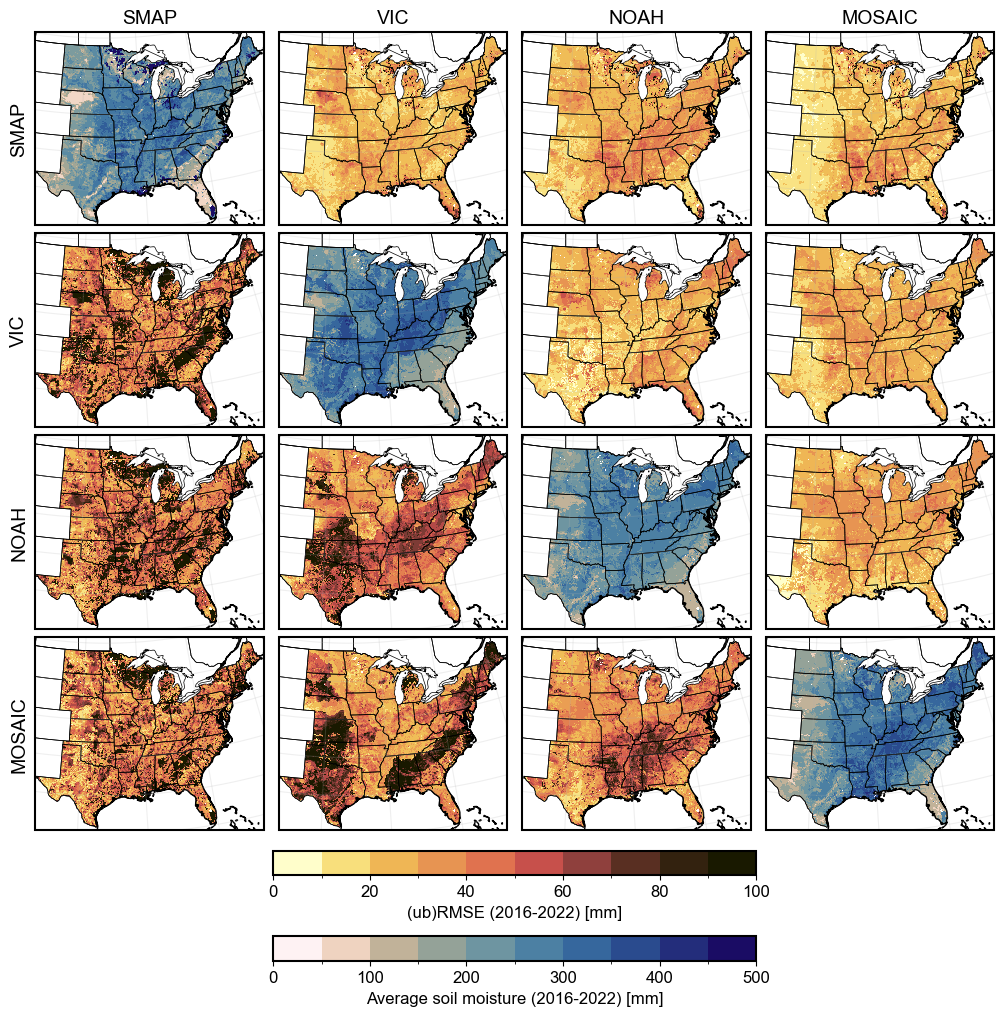

In [6]:
# Pairwise comparison
cmap_mean = lapaz_cmap
vmax_mean = 500.

cmap_diff = lajolla_cmap
vmax_diff = 100.

fig, axs = plt.subplots(4,4, figsize=(10,10), sharex=True, sharey=True, layout="constrained",
                    subplot_kw=dict(projection=ccrs.LambertConformal()))

# Loop through combinations
for ido1, obs_name1 in enumerate(obs_names):
    for ido2, obs_name2 in enumerate(obs_names):
        ax = axs[ido1, ido2]
        # Diagonal: mean
        if ido1 == ido2:
            pmean = ds_obs_all.isel(obs_name = ido1).mean(dim='time').plot(ax=ax, vmin=0, vmax=vmax_mean, levels=11, cmap=cmap_mean, add_colorbar=False, transform=ccrs.PlateCarree())
            ax.set_title('')
        # RMSE
        elif ido1 > ido2:
            ds_rmse = np.sqrt(((ds_obs_all.isel(obs_name = ido1) - ds_obs_all.isel(obs_name = ido2))**2).mean(dim='time'))
            ds_rmse.plot(ax=ax, vmin=0, vmax=vmax_diff, levels=11, cmap=cmap_diff, add_colorbar=False, transform=ccrs.PlateCarree())
        # ubRMSE
        elif ido2 > ido1:
            ds1_cenered = ds_obs_all.isel(obs_name = ido1) - ds_obs_all.isel(obs_name = ido1).mean(dim='time')
            ds2_cenered = ds_obs_all.isel(obs_name = ido2) - ds_obs_all.isel(obs_name = ido2).mean(dim='time')
            ds_rmse = np.sqrt(((ds1_cenered - ds2_cenered)**2).mean(dim='time'))
            pdiff = ds_rmse.plot(ax=ax, vmin=0, vmax=vmax_diff, levels=11, cmap=cmap_diff, add_colorbar=False, transform=ccrs.PlateCarree())
        
        # Tidy
        gl = ax.gridlines(draw_labels=True, x_inline=False, rotate_labels=False, alpha=0.2)
        gl.top_labels = False
        gl.left_labels = False
        gl.bottom_labels = False
        gl.right_labels = False

        if ido2 == 0:
            ax.text(-0.07, 0.5, obs_name1, horizontalalignment='center', fontsize=14,
                    rotation=90, verticalalignment='center', transform=ax.transAxes)
        if ido1 == 0:
            ax.set_title(obs_name2, fontsize=14)
        
        # No lat-lon labels
        # if ido2 == 3:
        #     gl.right_labels = True
        # if ido1 == 3:
        #     gl.bottom_labels = True
        

# Tidy
for ax in axs.flatten():
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.set_extent([-106, -73.5, 25, 49], ccrs.Geodetic())

# Colorbars
fig.colorbar(pmean, orientation="horizontal",
             label="Average soil moisture (2016-2022) [mm]",
             ax=axs, pad=0.02, shrink=0.5)

fig.colorbar(pdiff, orientation="horizontal",
             label="(ub)RMSE (2016-2022) [mm]",
             ax=axs, pad=0.02, shrink=0.5)
    
plt.savefig('../figs/main/fig2_pairwise_comparison.png', dpi=600)